### Pytorch를 비롯해 기타 필요한 패키지를 불러옵니다.

In [0]:
# 필요한 패키지 import!

import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn 
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.backends import cudnn

## 데이터 로더!

In [3]:
# 데이터 로드 준비 및 기타 설정

# 사용할 device 변수화 (gpu 혹은 cpu)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 트레이닝 에폭 수 선정 (전체 데이터를 한바퀴 돌면 1에폭 돌았다고 표현합니다)
num_epoch = 50

# gpu는 한계가 있기 때문에 60000개 데이터를 한번에 forward 하지 못합니다.
# 이를 100개로 구성된 600개의 그룹으로 재구성해 한 그룹씩 모델에 forward 해줍니다!
batch_size = 100

# -1 ~ 1 사이로 인풋 값 normalization 해주기
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
                                     std=(0.5, 0.5, 0.5))])

# MNIST dataset
# root : download할 dir (혹은 로드할 dir)
# train : 트레인 데이터인지 테스트 데이터인지
# transform : 로드한 데이터 변환
# download : 지정된 dir로 데이터 다운로드
mnist = datasets.MNIST(root='./data/mnist',
                       train=True,
                       transform=transform,
                       download=True)

# 데이터 로더!! 
# batch size : batch size를 기준으로 첫번째 디맨션(배치 디맨션) 구성
# shuffle : True일 때 에폭마다 데이터 정렬을 랜덤하게
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

print('The number of batches: ',len(data_loader))

The number of batches:  600


## 데이터가 잘 불러와졌는지 확인해주세요~

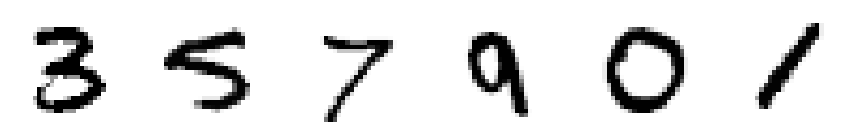

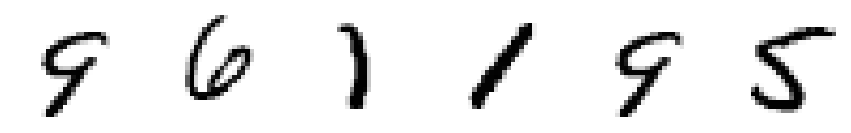

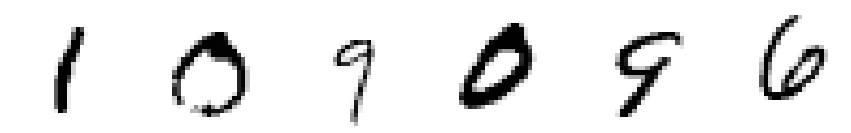

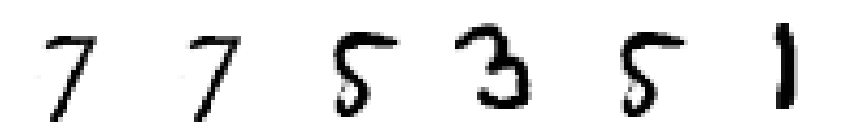

In [4]:
# 우리 모델에서는 -1 ~ 1 사이의 값을 뽑아주기 때문에, 이미지 출력을 위해 0 ~ 1 사이 값으로 변환하는 함수가 필요합니다.
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# 학습 데이터 출력을 위한 함수입니다.
def show_images(image, n_row):
    for _ in range(n_row):  
        index=np.random.choice(100, 6)
        images =image.numpy()[index]    
        plt.figure(figsize=(15,90))    
    for a in range(161, 167):    
        plt.subplot(a)
        plt.imshow(images[a-161])
        plt.xticks([])
        plt.yticks([])    
    plt.show()  

# 학습 데이터가 어떻게 생겼는지 출력해 볼 수 있습니다.
for i, (image,_) in enumerate(data_loader): 
    show_images(denorm(image.squeeze()), 4)
    break

### 이미지 출력 함수

In [0]:
def test_and_show(G, fixed_z):
    G.eval()
    fake_images = G(fixed_z).view(-1, 28, 28)  
    fake_images = (fake_images+1)/2
    images_to_show = fake_images.data.cpu().squeeze().numpy()
    images_row = images_to_show[:6] 

    plt.figure(figsize=(10,60))
    for a in range(161, 167):    
        plt.subplot(a)
        plt.imshow(images_row[a-161])
        plt.xticks([])
        plt.yticks([])    
    plt.show() 

# GAN: Generative Adversarial Network

### 속이려는 G와 속지 않으려는 D의 싸움!


---


![대체 텍스트](https://skymind.ai/images/wiki/GANs.png)

## Training:

### Discriminator 학습: Real Image와 Fake Image를 받아 각각 1, 0으로 판단하도록 학습 (진짜를 진짜로, 가짜를 가짜로 판단)

### Generator 학습 : Random Noise를 인풋으로 받아 Fake Image를 생성하고, 생성한 Fake Image로 Discriminator를 속이도록 학습 (Discriminator가 1로 판단하도록 학습)


---


![대체 텍스트](https://datascience.foundation/backend/web/uploads/blog/GAN-Algorithm.png)



---

D의 맥스값 찾는 업데이트 먼저(D 학습 먼저), 이후  G의 민값 찾는 업데이트

### 직접 입력해봅시다

In [0]:
# 가로 세로 (28 x 28)인 이미지를 하나의 벡터로 만들면 784 디맨션
img_dim = 784

# 임베딩 디맨션을 설정해주세요! (20 ~ 100)
z_dim = 64

# Discriminator의 중간 레이어 디맨션을 설정해주세요! (200 ~ 400)
D_intermidiate_dim = 256

# Generator의 중간 레이어 디맨션을 설정해주세요! (200 ~ 400)
G_intermediate_dim = 256


### Discriminator 입니다

In [0]:
# Discriminator
D = nn.Sequential(
    
    nn.Linear(img_dim, D_intermidiate_dim),
    nn.LeakyReLU(0.01), # LeakyReLu: 음수값을 어느정도 살려놓는 ReLU
    nn.Linear(D_intermidiate_dim, D_intermidiate_dim),
    nn.LeakyReLU(0.01),
    nn.Linear(D_intermidiate_dim, 1),
    nn.Sigmoid() # 0 ~ 1

).to(device)

### Generator 입니다

In [0]:
# Generator 
G = nn.Sequential(
    
    nn.Linear(z_dim, G_intermediate_dim),
    nn.ReLU(),
    nn.Linear(G_intermediate_dim, G_intermediate_dim),
    nn.ReLU(),
    nn.Linear(G_intermediate_dim, img_dim),
    nn.Tanh() # -1 ~ 1

).to(device)

### Loss 및 Optimizer 선정

In [0]:
# Binary cross entropy loss and Adam optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [0]:
# test에서 항상 뽑아볼 수 있는 고정된 z를 사전에 뽑아둡니다.
fixed_z = torch.randn(batch_size, z_dim).to(device)

### Training 코드입니다

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [0/200], Step[300/600], d_loss: 0.0376, g_loss: 3.8791, D(x): 1.00, D(G(z)): 0.04


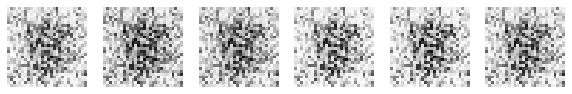

Epoch [0/200], Step[600/600], d_loss: 0.1577, g_loss: 3.9681, D(x): 0.98, D(G(z)): 0.12


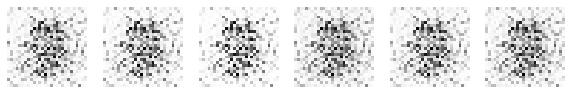

Epoch [1/200], Step[300/600], d_loss: 2.2191, g_loss: 0.6446, D(x): 0.39, D(G(z)): 0.37


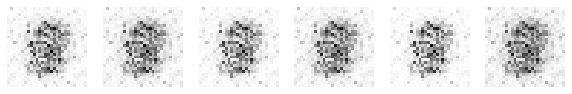

Epoch [1/200], Step[600/600], d_loss: 2.0008, g_loss: 1.2381, D(x): 0.47, D(G(z)): 0.50


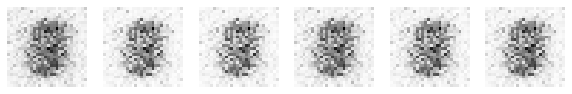

Epoch [2/200], Step[300/600], d_loss: 0.2255, g_loss: 3.5418, D(x): 0.91, D(G(z)): 0.09


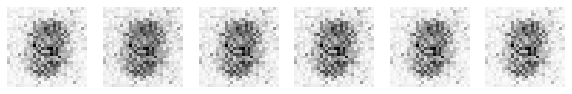

Epoch [2/200], Step[600/600], d_loss: 0.4345, g_loss: 3.1421, D(x): 0.83, D(G(z)): 0.11


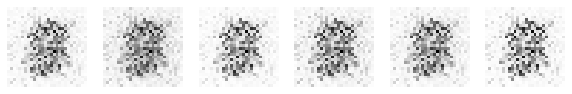

Epoch [3/200], Step[300/600], d_loss: 0.2200, g_loss: 3.2192, D(x): 0.94, D(G(z)): 0.12


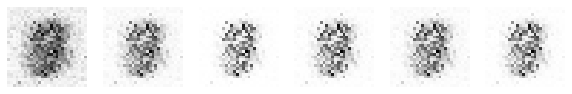

Epoch [3/200], Step[600/600], d_loss: 0.4928, g_loss: 2.8331, D(x): 0.92, D(G(z)): 0.27


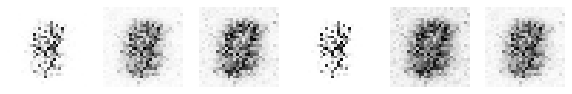

Epoch [4/200], Step[300/600], d_loss: 0.3033, g_loss: 2.7140, D(x): 0.88, D(G(z)): 0.11


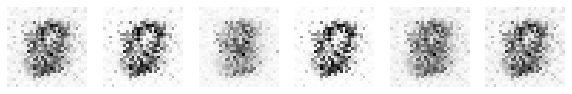

Epoch [4/200], Step[600/600], d_loss: 0.7994, g_loss: 1.7999, D(x): 0.78, D(G(z)): 0.26


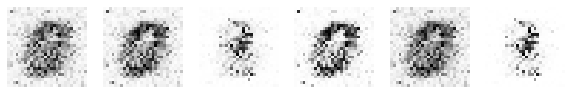

Epoch [5/200], Step[300/600], d_loss: 0.2073, g_loss: 4.3876, D(x): 0.96, D(G(z)): 0.10


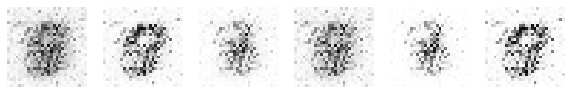

Epoch [5/200], Step[600/600], d_loss: 0.7408, g_loss: 3.6141, D(x): 0.86, D(G(z)): 0.26


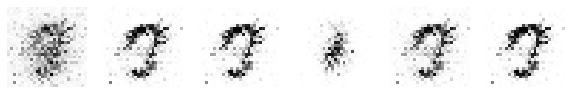

Epoch [6/200], Step[300/600], d_loss: 0.1847, g_loss: 4.0135, D(x): 0.92, D(G(z)): 0.05


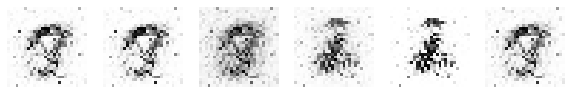

Epoch [6/200], Step[600/600], d_loss: 0.1890, g_loss: 3.4007, D(x): 0.94, D(G(z)): 0.08


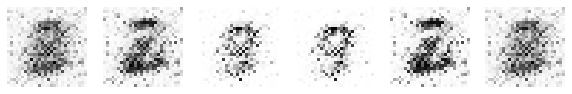

Epoch [7/200], Step[300/600], d_loss: 0.5090, g_loss: 4.4506, D(x): 0.86, D(G(z)): 0.08


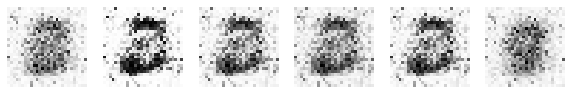

Epoch [7/200], Step[600/600], d_loss: 0.6618, g_loss: 3.1598, D(x): 0.82, D(G(z)): 0.19


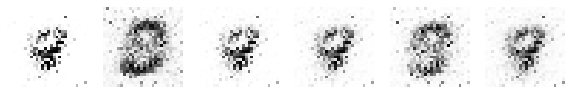

Epoch [8/200], Step[300/600], d_loss: 0.6731, g_loss: 4.1323, D(x): 0.81, D(G(z)): 0.17


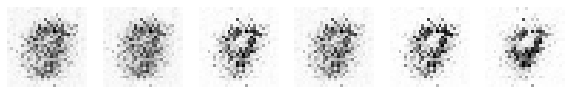

Epoch [8/200], Step[600/600], d_loss: 0.9086, g_loss: 2.1492, D(x): 0.71, D(G(z)): 0.22


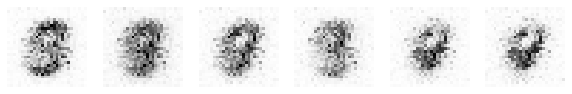

Epoch [9/200], Step[300/600], d_loss: 0.4965, g_loss: 3.5874, D(x): 0.90, D(G(z)): 0.22


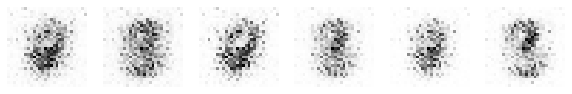

Epoch [9/200], Step[600/600], d_loss: 0.5312, g_loss: 2.9264, D(x): 0.79, D(G(z)): 0.16


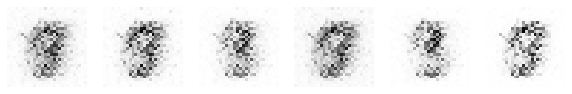

Epoch [10/200], Step[300/600], d_loss: 0.5281, g_loss: 2.4649, D(x): 0.79, D(G(z)): 0.17


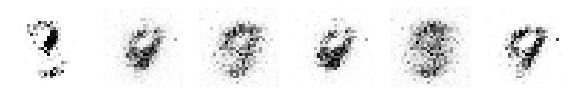

Epoch [10/200], Step[600/600], d_loss: 1.0922, g_loss: 1.9594, D(x): 0.65, D(G(z)): 0.21


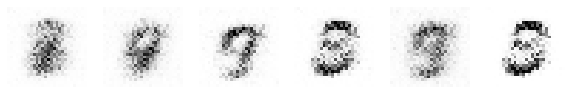

Epoch [11/200], Step[300/600], d_loss: 0.9319, g_loss: 1.7520, D(x): 0.72, D(G(z)): 0.28


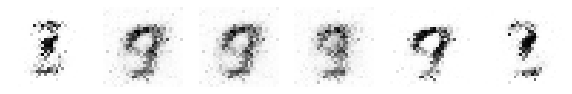

Epoch [11/200], Step[600/600], d_loss: 0.6736, g_loss: 2.8093, D(x): 0.82, D(G(z)): 0.28


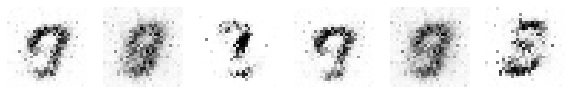

Epoch [12/200], Step[300/600], d_loss: 0.3223, g_loss: 3.6005, D(x): 0.86, D(G(z)): 0.06


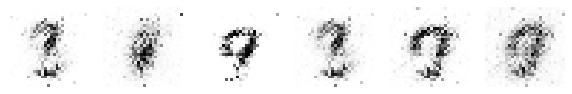

Epoch [12/200], Step[600/600], d_loss: 0.2798, g_loss: 3.7835, D(x): 0.93, D(G(z)): 0.07


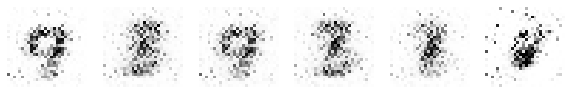

Epoch [13/200], Step[300/600], d_loss: 0.7094, g_loss: 3.2233, D(x): 0.83, D(G(z)): 0.27


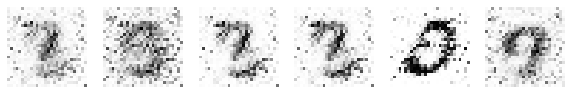

Epoch [13/200], Step[600/600], d_loss: 0.4182, g_loss: 3.0189, D(x): 0.91, D(G(z)): 0.16


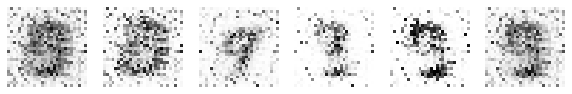

Epoch [14/200], Step[300/600], d_loss: 0.4292, g_loss: 4.0403, D(x): 0.83, D(G(z)): 0.07


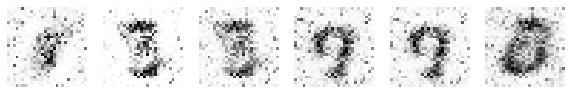

Epoch [14/200], Step[600/600], d_loss: 0.3648, g_loss: 4.1668, D(x): 0.87, D(G(z)): 0.06


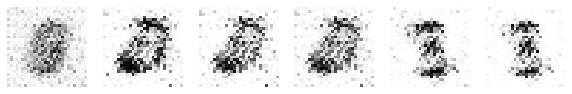

Epoch [15/200], Step[300/600], d_loss: 0.4306, g_loss: 3.9517, D(x): 0.88, D(G(z)): 0.17


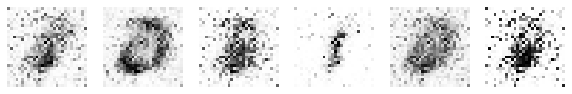

Epoch [15/200], Step[600/600], d_loss: 0.4724, g_loss: 2.6352, D(x): 0.83, D(G(z)): 0.11


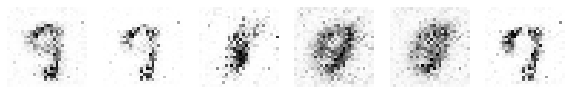

Epoch [16/200], Step[300/600], d_loss: 0.5237, g_loss: 3.3652, D(x): 0.90, D(G(z)): 0.19


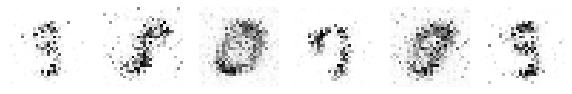

Epoch [16/200], Step[600/600], d_loss: 0.2027, g_loss: 6.1567, D(x): 0.89, D(G(z)): 0.02


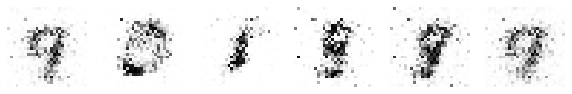

Epoch [17/200], Step[300/600], d_loss: 0.1857, g_loss: 3.7752, D(x): 0.97, D(G(z)): 0.13


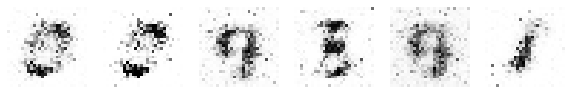

Epoch [17/200], Step[600/600], d_loss: 0.1785, g_loss: 4.9320, D(x): 0.95, D(G(z)): 0.10


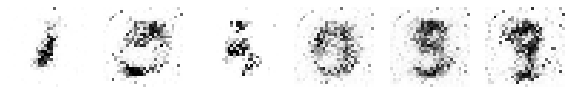

Epoch [18/200], Step[300/600], d_loss: 0.2895, g_loss: 5.0966, D(x): 0.91, D(G(z)): 0.08


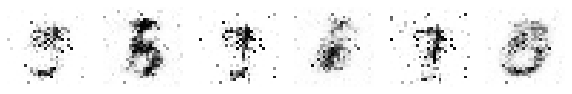

Epoch [18/200], Step[600/600], d_loss: 0.1307, g_loss: 3.5998, D(x): 0.95, D(G(z)): 0.06


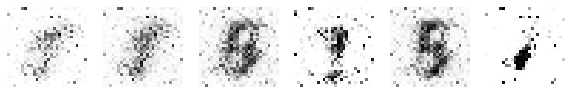

Epoch [19/200], Step[300/600], d_loss: 0.2858, g_loss: 5.0120, D(x): 0.96, D(G(z)): 0.13


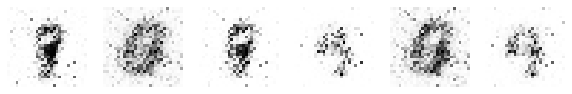

Epoch [19/200], Step[600/600], d_loss: 0.3102, g_loss: 7.1897, D(x): 0.92, D(G(z)): 0.06


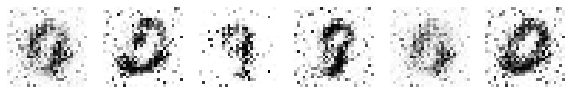

Epoch [20/200], Step[300/600], d_loss: 0.3670, g_loss: 4.8212, D(x): 0.91, D(G(z)): 0.13


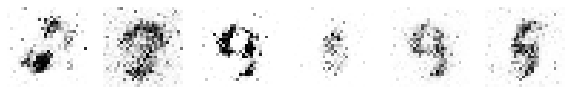

Epoch [20/200], Step[600/600], d_loss: 0.2651, g_loss: 5.0393, D(x): 0.94, D(G(z)): 0.11


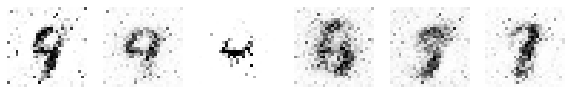

Epoch [21/200], Step[300/600], d_loss: 0.2196, g_loss: 4.3797, D(x): 0.94, D(G(z)): 0.06


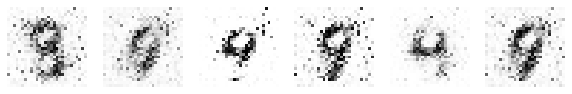

Epoch [21/200], Step[600/600], d_loss: 0.2241, g_loss: 3.4775, D(x): 0.94, D(G(z)): 0.07


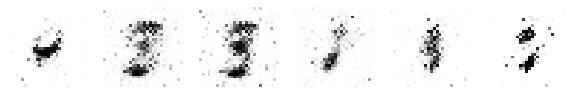

Epoch [22/200], Step[300/600], d_loss: 0.1857, g_loss: 4.5289, D(x): 0.92, D(G(z)): 0.03


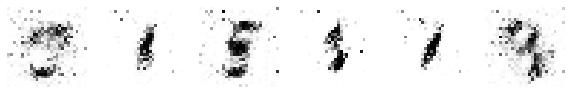

Epoch [22/200], Step[600/600], d_loss: 0.2293, g_loss: 4.7008, D(x): 0.91, D(G(z)): 0.07


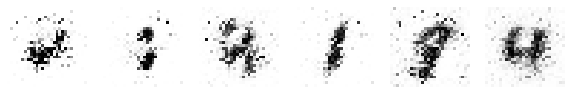

Epoch [23/200], Step[300/600], d_loss: 0.3427, g_loss: 3.7173, D(x): 0.87, D(G(z)): 0.08


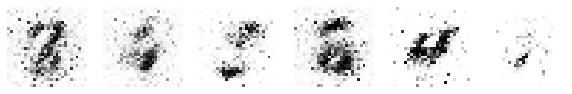

Epoch [23/200], Step[600/600], d_loss: 0.2469, g_loss: 3.1670, D(x): 0.92, D(G(z)): 0.10


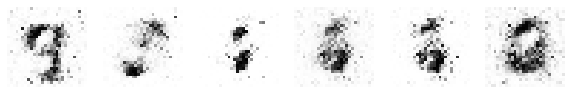

Epoch [24/200], Step[300/600], d_loss: 0.4422, g_loss: 3.5025, D(x): 0.87, D(G(z)): 0.11


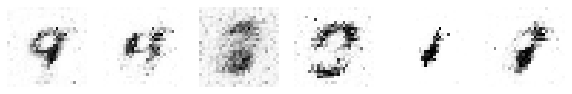

Epoch [24/200], Step[600/600], d_loss: 0.1787, g_loss: 4.6695, D(x): 0.92, D(G(z)): 0.04


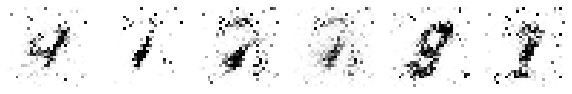

Epoch [25/200], Step[300/600], d_loss: 0.2097, g_loss: 4.8679, D(x): 0.95, D(G(z)): 0.11


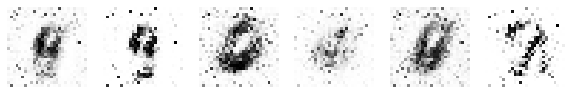

Epoch [25/200], Step[600/600], d_loss: 0.3725, g_loss: 4.1818, D(x): 0.85, D(G(z)): 0.04


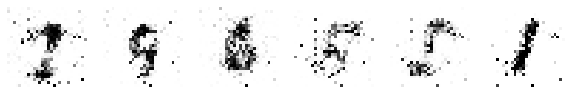

Epoch [26/200], Step[300/600], d_loss: 0.2865, g_loss: 4.7130, D(x): 0.91, D(G(z)): 0.08


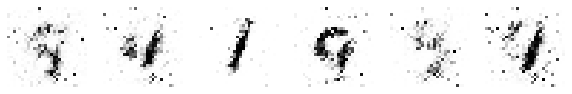

Epoch [26/200], Step[600/600], d_loss: 0.2805, g_loss: 4.2446, D(x): 0.90, D(G(z)): 0.04


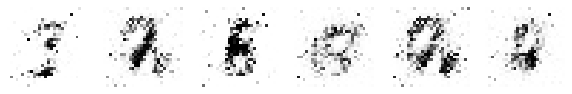

Epoch [27/200], Step[300/600], d_loss: 0.2339, g_loss: 4.6867, D(x): 0.94, D(G(z)): 0.08


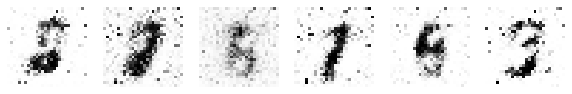

Epoch [27/200], Step[600/600], d_loss: 0.2692, g_loss: 3.9372, D(x): 0.95, D(G(z)): 0.13


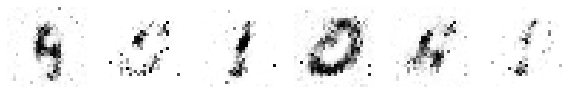

Epoch [28/200], Step[300/600], d_loss: 0.3810, g_loss: 3.6540, D(x): 0.85, D(G(z)): 0.06


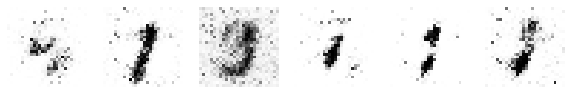

Epoch [28/200], Step[600/600], d_loss: 0.2864, g_loss: 4.2646, D(x): 0.91, D(G(z)): 0.05


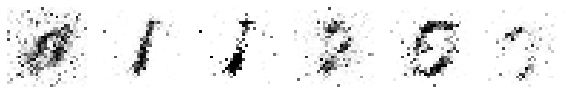

Epoch [29/200], Step[300/600], d_loss: 0.4644, g_loss: 4.2388, D(x): 0.89, D(G(z)): 0.13


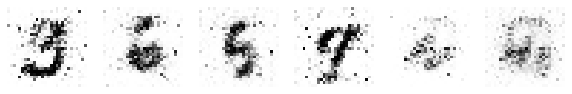

Epoch [29/200], Step[600/600], d_loss: 0.4079, g_loss: 2.9928, D(x): 0.89, D(G(z)): 0.13


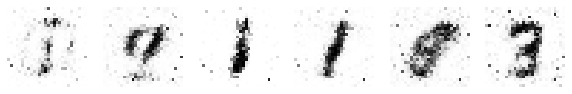

Epoch [30/200], Step[300/600], d_loss: 0.3433, g_loss: 4.7216, D(x): 0.88, D(G(z)): 0.09


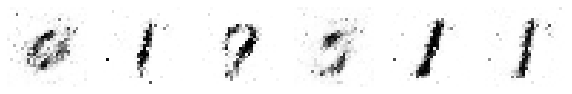

Epoch [30/200], Step[600/600], d_loss: 0.6639, g_loss: 2.2731, D(x): 0.85, D(G(z)): 0.21


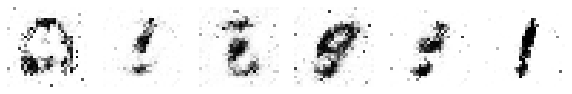

Epoch [31/200], Step[300/600], d_loss: 0.4439, g_loss: 3.0480, D(x): 0.87, D(G(z)): 0.15


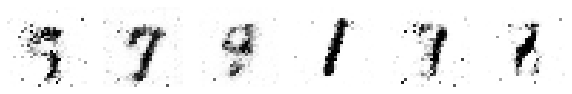

Epoch [31/200], Step[600/600], d_loss: 0.3005, g_loss: 4.1313, D(x): 0.88, D(G(z)): 0.05


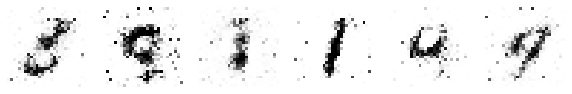

Epoch [32/200], Step[300/600], d_loss: 0.3043, g_loss: 3.2439, D(x): 0.89, D(G(z)): 0.11


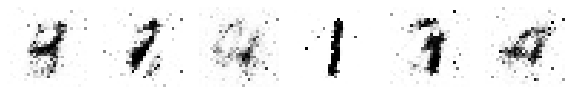

Epoch [32/200], Step[600/600], d_loss: 0.3819, g_loss: 3.1075, D(x): 0.96, D(G(z)): 0.22


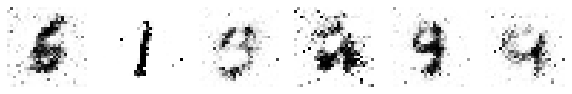

Epoch [33/200], Step[300/600], d_loss: 0.3634, g_loss: 3.9089, D(x): 0.92, D(G(z)): 0.14


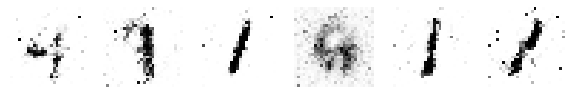

Epoch [33/200], Step[600/600], d_loss: 0.3650, g_loss: 3.2357, D(x): 0.83, D(G(z)): 0.06


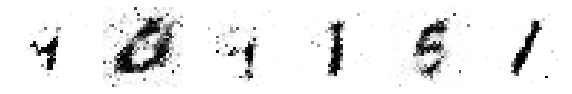

Epoch [34/200], Step[300/600], d_loss: 0.5108, g_loss: 3.6259, D(x): 0.83, D(G(z)): 0.13


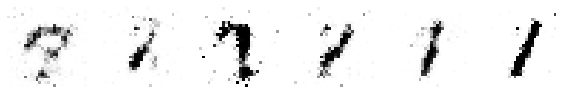

Epoch [34/200], Step[600/600], d_loss: 0.3782, g_loss: 3.4016, D(x): 0.88, D(G(z)): 0.09


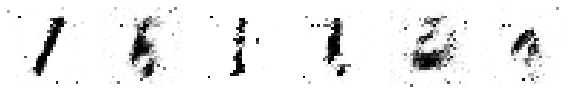

Epoch [35/200], Step[300/600], d_loss: 0.4398, g_loss: 2.7380, D(x): 0.83, D(G(z)): 0.07


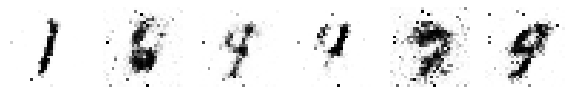

Epoch [35/200], Step[600/600], d_loss: 0.3471, g_loss: 2.2290, D(x): 0.89, D(G(z)): 0.13


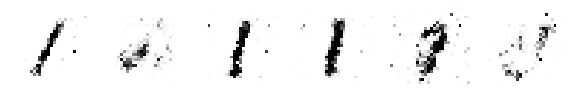

Epoch [36/200], Step[300/600], d_loss: 0.5457, g_loss: 3.1542, D(x): 0.81, D(G(z)): 0.13


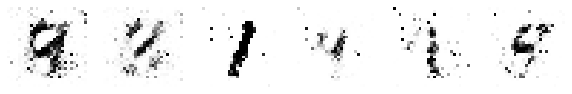

Epoch [36/200], Step[600/600], d_loss: 0.3785, g_loss: 3.5252, D(x): 0.94, D(G(z)): 0.18


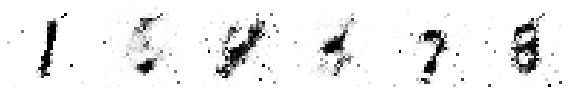

Epoch [37/200], Step[300/600], d_loss: 0.6178, g_loss: 3.0380, D(x): 0.81, D(G(z)): 0.15


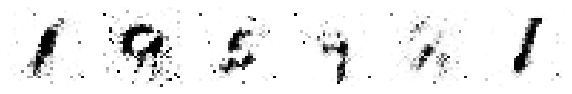

Epoch [37/200], Step[600/600], d_loss: 0.5182, g_loss: 2.8484, D(x): 0.86, D(G(z)): 0.18


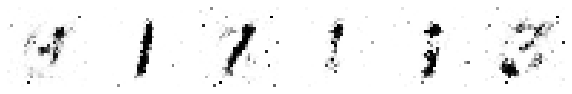

Epoch [38/200], Step[300/600], d_loss: 0.4184, g_loss: 2.6722, D(x): 0.84, D(G(z)): 0.12


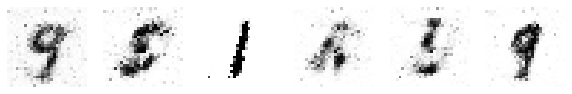

Epoch [38/200], Step[600/600], d_loss: 0.5480, g_loss: 3.0838, D(x): 0.80, D(G(z)): 0.14


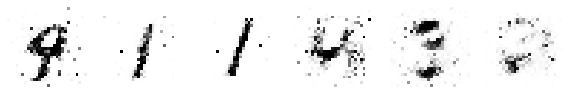

Epoch [39/200], Step[300/600], d_loss: 0.6795, g_loss: 3.6079, D(x): 0.76, D(G(z)): 0.11


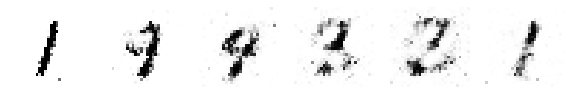

Epoch [39/200], Step[600/600], d_loss: 0.5804, g_loss: 3.3894, D(x): 0.83, D(G(z)): 0.16


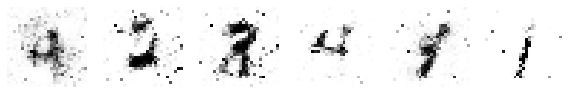

Epoch [40/200], Step[300/600], d_loss: 0.5223, g_loss: 3.3769, D(x): 0.83, D(G(z)): 0.14


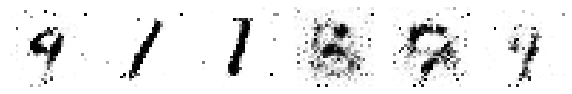

Epoch [40/200], Step[600/600], d_loss: 0.5465, g_loss: 2.8150, D(x): 0.84, D(G(z)): 0.18


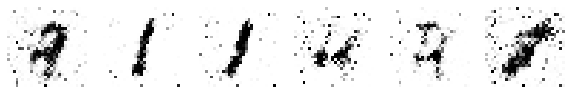

Epoch [41/200], Step[300/600], d_loss: 0.7387, g_loss: 2.9723, D(x): 0.75, D(G(z)): 0.11


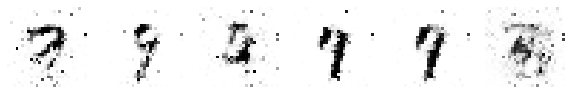

Epoch [41/200], Step[600/600], d_loss: 0.5118, g_loss: 2.7154, D(x): 0.89, D(G(z)): 0.22


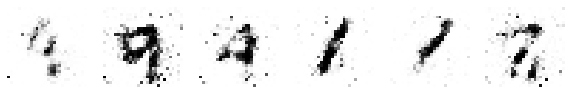

Epoch [42/200], Step[300/600], d_loss: 0.5900, g_loss: 2.5146, D(x): 0.85, D(G(z)): 0.23


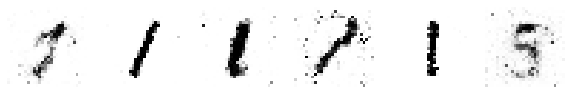

Epoch [42/200], Step[600/600], d_loss: 0.5477, g_loss: 2.9444, D(x): 0.80, D(G(z)): 0.16


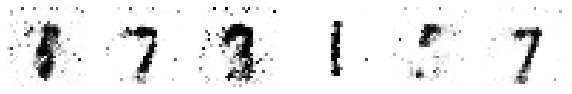

Epoch [43/200], Step[300/600], d_loss: 0.7102, g_loss: 2.0534, D(x): 0.79, D(G(z)): 0.17


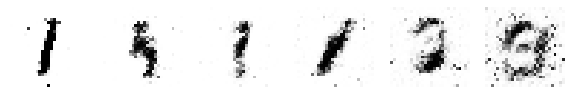

Epoch [43/200], Step[600/600], d_loss: 0.4216, g_loss: 2.8316, D(x): 0.86, D(G(z)): 0.15


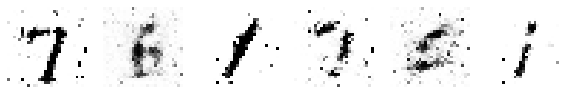

Epoch [44/200], Step[300/600], d_loss: 0.3656, g_loss: 2.5596, D(x): 0.91, D(G(z)): 0.18


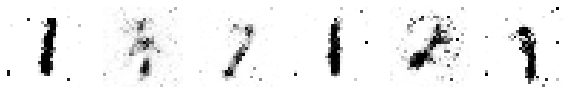

Epoch [44/200], Step[600/600], d_loss: 0.6212, g_loss: 2.4900, D(x): 0.81, D(G(z)): 0.18


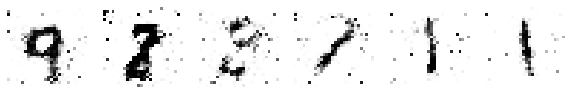

Epoch [45/200], Step[300/600], d_loss: 0.6053, g_loss: 2.9515, D(x): 0.89, D(G(z)): 0.28


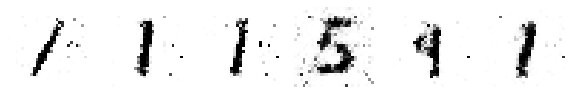

Epoch [45/200], Step[600/600], d_loss: 0.5974, g_loss: 2.9420, D(x): 0.80, D(G(z)): 0.16


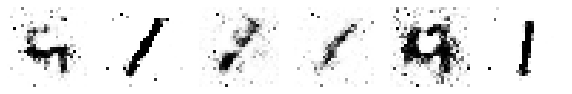

Epoch [46/200], Step[300/600], d_loss: 0.5302, g_loss: 1.8690, D(x): 0.82, D(G(z)): 0.14


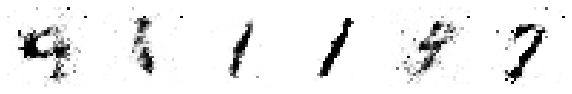

Epoch [46/200], Step[600/600], d_loss: 0.6327, g_loss: 2.9262, D(x): 0.73, D(G(z)): 0.08


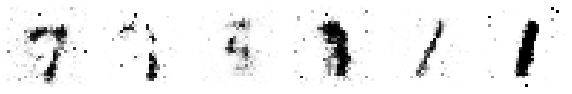

Epoch [47/200], Step[300/600], d_loss: 0.8772, g_loss: 2.7363, D(x): 0.67, D(G(z)): 0.10


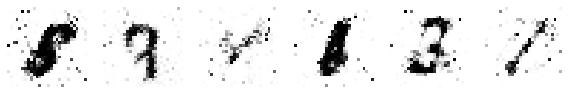

Epoch [47/200], Step[600/600], d_loss: 0.6822, g_loss: 2.2525, D(x): 0.88, D(G(z)): 0.30


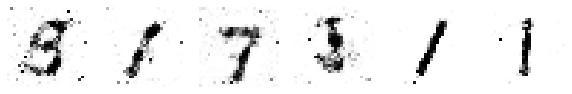

Epoch [48/200], Step[300/600], d_loss: 0.6675, g_loss: 2.1840, D(x): 0.78, D(G(z)): 0.19


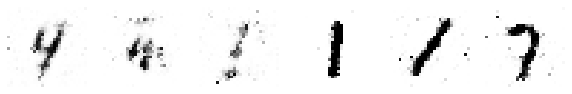

Epoch [48/200], Step[600/600], d_loss: 0.5463, g_loss: 2.5461, D(x): 0.86, D(G(z)): 0.21


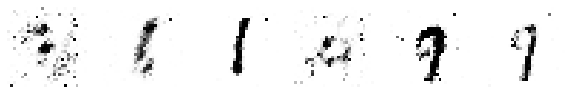

Epoch [49/200], Step[300/600], d_loss: 0.5812, g_loss: 2.4856, D(x): 0.82, D(G(z)): 0.18


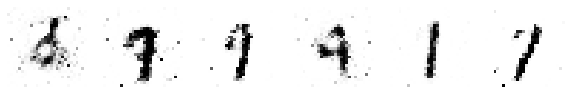

Epoch [49/200], Step[600/600], d_loss: 0.5324, g_loss: 2.4534, D(x): 0.82, D(G(z)): 0.15


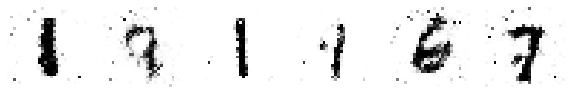

In [11]:
# Start training
for epoch in range(num_epoch):
    for i, (images, _) in enumerate(data_loader):
        
        G.train()
        D.train()
      
        # (B,1,28,28) => (B,784)
        images = images.view(batch_size, -1).to(device)
        
        # 진짜라는 label, 가짜라는 label을 만들어줍니다. batch_size만큼
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        
        #============= Train the discriminator =============#
        
        # Discriminator에게 진짜 이미지를 진짜라고 가르쳐 줍니다.
        outputs = D(images) # 진짜 이미지를 Discriminator에 넣어줍니다.
        d_loss_real = criterion(outputs, real_labels) # Discriminator가 진짜 이미지는 1로 판단하도록 로스를 발생시켜 줍니다.
        real_score = outputs
        
        # Discriminator에게 가짜 이미지를 가짜라고 가르쳐 줍니다.
        z = torch.randn(batch_size, z_dim).to(device) # latent vector z를 N(0,1)에서 random sampling 해줍니다.
        fake_images = G(z) # Generator에 z를 인풋으로 넣어줍니다.
        outputs = D(fake_images.detach()) # Discriminator에 가짜이미지를 넣어줍니다. 지금은 detach 안써도 되지만 계산량 줄여주는 기능(계산그래프 끊어버린다)
        d_loss_fake = criterion(outputs, fake_labels) # Discriminator가 가짜 이미지는 0으로 판단하도록 로스를 발생시켜 줍니다.
        fake_score = outputs
        
        # Backprop + Optimize (Discriminator 업데이트!!)
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #=============== Train the generator ===============#
        
        # Generator가 Discriminator를 속여 가짜 이미지를 진짜로 판단하게끔 학습합니다. (ADVERSARIAL)
        z = torch.randn(batch_size, z_dim).to(device) # latent vector z를 N(0,1)에서 random sampling 해줍니다.
        fake_images = G(z) # Generator에 z를 인풋으로 넣어줍니다.
        outputs = D(fake_images) # Discriminator에 가짜이미지를 넣어줍니다.
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels) # Discriminator가 가짜 이미지를 1로 판단하도록 로스를 발생시켜 줍니다.
        
        # Backprop + Optimize (Generator 업데이트!!)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch, 200, i+1, len(data_loader), d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))
        if (i+1) % 300 == 0:
            test_and_show(G, torch.randn(batch_size, z_dim).to(device))


### 샘플 이미지 뽑아보기

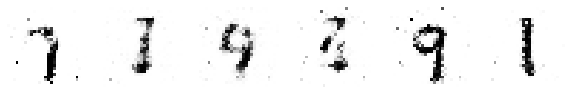

In [12]:
test_and_show(G, fixed_z)

### 학습시킨 모델을 저장시켜봅시다

##### 그런데 우리는 뭘 저장하는 걸까요?

In [0]:
# Save the trained parameters 
torch.save(G.state_dict(), './data/generator.pkl')
torch.save(D.state_dict(), './data/discriminator.pkl')

### 미리 학습시켜놓은 모델을 로드해 결과를 뽑아봅시다

In [0]:
# Load the trained parameters
G.load_state_dict(torch.load('./data/generator_200.pkl'))

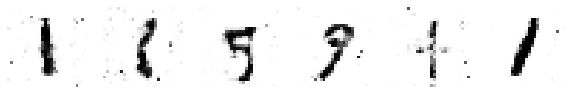

In [16]:
test_and_show(G, fixed_z)